# EM clustering

In [82]:
from sklearn.mixture import GaussianMixture
import pyreadr
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import pandas as pd

In [84]:
data = pyreadr.read_r('syntdata0.RDS')
df = data[None]
#rescaling -> not mandatory for EM since it allowws elliptic clusters
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled)
df_scaled

,0,1
0,0.214503,0.244611
1,0.111409,0.171936
2,0.160825,0.327017
3,0.175192,0.265707
4,0.163017,0.229353
...,...,...
145,0.998980,0.292157
146,0.888934,0.333047
147,0.777769,0.468284
148,0.855564,0.367697


There are two different procedures to obtain the same results. The first one uses a set of data to estimate model parameters and then predicts their labels. The second one estimates model parameters with some data and then can be used to find the labels of other data.

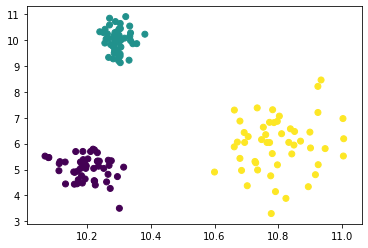

In [85]:
# define the model
em = GaussianMixture(n_components=3)
# find model parameters using 'df_scaled', 
# then predict the labels for 'df_scaled'
em_res = em.fit_predict(df)
plt.scatter(df[0].values, df[1].values, c=em_res)

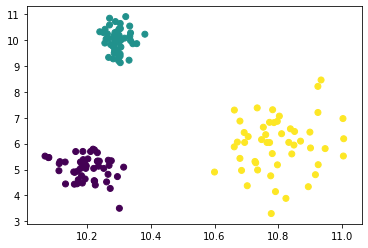

In [74]:
# Alternatively find the model parameters
em_fit = em.fit(df)
# Then predict the labels for other data
em_pred = em.predict(df)
# or use em.labels_ to obtain the labels of the data used to find the model parameters
# em_pred = em.labels_
plt.scatter(df[0].values, df[1].values, c=em_pred)

In [75]:
em.get_params()

{'covariance_type': 'full',
 'init_params': 'kmeans',
 'max_iter': 100,
 'means_init': None,
 'n_components': 3,
 'n_init': 1,
 'precisions_init': None,
 'random_state': None,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'verbose': 0,
 'verbose_interval': 10,
 'warm_start': False,
 'weights_init': None}

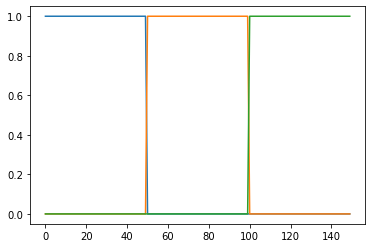

In [87]:
plt.plot(em.predict_proba(df))
plt.show()

In [77]:
print('The means are:')
for x, y in em.means_:
    print('(%f, %f)' %(x, y))
print('The covariance matrices are:')
for i in em.covariances_:
    print(i)

The means are:
(10.198216, 5.050353)
(10.295462, 9.988142)
(10.800793, 5.971320)
The covariance matrices are:
[[ 0.00324944 -0.00623733]
 [-0.00623733  0.2096181 ]]
[[ 0.00075987 -0.00041477]
 [-0.00041477  0.19184871]]
[[0.00957217 0.0155974 ]
 [0.0155974  1.09020613]]


EM is similar to representative based algorithms, in both cases the number of clusters must be set a priori. The difference is that EM is probabilistic, while the others are distance based. For this reason with EM it's possible to obtain elliptical clusters, while with the others the shape is defined by the distance used (e.g. if the distance is Euclidean the clusters are circles).\
Since it's probabilistic, EM depends on the seed. Different seeds can lead to different results, even if the dataset is the same.

# DBSCAN

In [78]:
from sklearn.cluster import DBSCAN

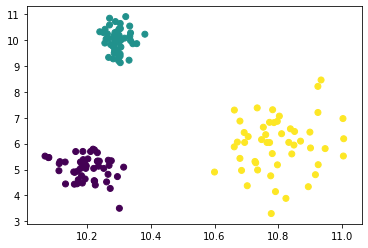

In [79]:
dbscan = DBSCAN(eps=0.2, min_samples=3).fit(df_scaled)
plt.scatter(df[0], df[1], c=dbscan.labels_)

For a good result it's very important to set correctly ```eps``` and ```min_samples```. \
```eps```: maximum distance between two samples for one to be considered as in the neighborhood of the other. \
```min_samples```: minimum number of samples in a neighborhood for a point to be considered as a core point. 

These two are hyperparameters, so must be set by the user and are not learnt during the training.

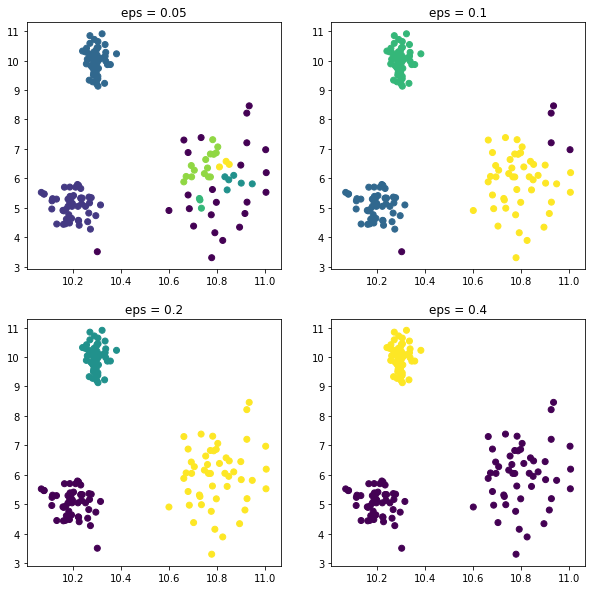

In [80]:
epsilon = [0.05, 0.1, 0.2, 0.4]
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i in range(2):
    for j in range(2):
        #for eps in [0.1, 0.2, 0.4, 0.8]:
        eps = epsilon[i*2+j]
        dbscan = DBSCAN(eps=eps, min_samples=3).fit(df_scaled)
        axs[i, j].scatter(df[0], df[1], c=dbscan.labels_)
        axs[i, j].set_title('eps = ' + str(eps))
plt.show()

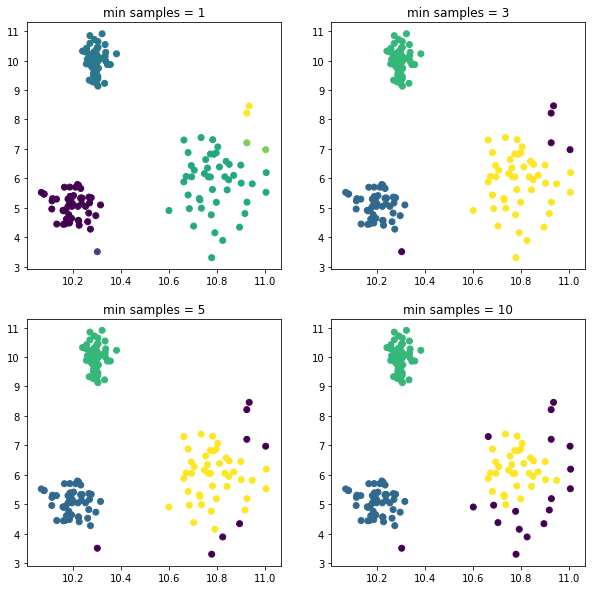

In [81]:
minS = [1, 3, 5, 10]
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i in range(2):
    for j in range(2):
        #for eps in [0.1, 0.2, 0.4, 0.8]:
        mini = minS[i*2+j]
        dbscan = DBSCAN(eps=0.1, min_samples=mini).fit(df_scaled)
        axs[i, j].scatter(df[0], df[1], c=dbscan.labels_)
        axs[i, j].set_title('min samples = ' + str(mini))
plt.show()

Dark points have been classified by the algorithm as 'noise points' so they don't belong to any cluster.

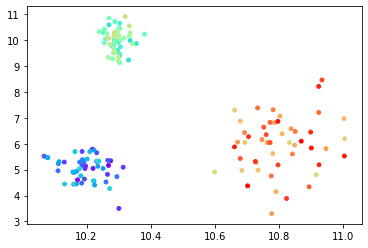

In [88]:
dbscan = DBSCAN(eps=0.001, min_samples=1).fit(df_scaled)
plt.scatter(df[0], df[1], c=dbscan.labels_, cmap='rainbow', s=15)
# lots of clusters, one item for each one of them

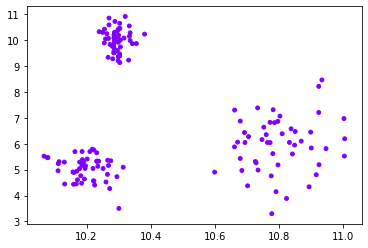

In [89]:
dbscan = DBSCAN(eps=1, min_samples=1).fit(df_scaled)
plt.scatter(df[0], df[1], c=dbscan.labels_, cmap='rainbow', s=15)
# only one cluster

# Cluster validation

### Sum of squares (internal validation)

In [90]:
from sklearn.cluster import KMeans

In [91]:
SSQ = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k).fit(df_scaled)
    SSQ.append(kmeans.inertia_)

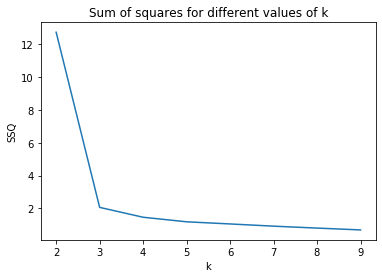

In [99]:
plt.plot(range(2,10), SSQ)
plt.xlabel('k')
plt.ylabel('SSQ')
plt.title('Sum of squares for different values of k')
plt.show()

For the elbow rule, the best value is 3. 

Max log likelihood cannot be used to find the best hyperparameters, it works only for parameters.

In [96]:
from sklearn.metrics import silhouette_score as sil_sc

In [97]:
sil = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k).fit(df_scaled)
    sil.append(sil_sc(df_scaled, kmeans.labels_))

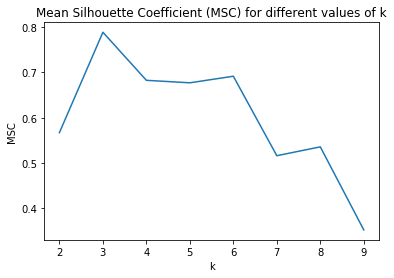

In [100]:
plt.plot(range(2,10), sil)
plt.xlabel('k')
plt.ylabel('MSC')
plt.title('Mean Silhouette Coefficient (MSC) for different values of k')
plt.show()

The goal is to maximize MSC, so k=3 is the best one. \
More robust than SSQ

This is the result with only one hyperparameter, when we have two of them with have to check for every pair of values. We can prepare a grid where every point on the grid is a pair and evaluate the MSC/SSQ for each point, then we pick the best one. \
This technique has been used widely, but now there are also other methods.